In [1]:
import joblib as jb
import pandas as pd
import psycopg2
import sqlalchemy 
import pyodbc
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from collections import Counter
from mlxtend.plotting import plot_decision_regions

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
df=pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [6]:
df['type']=df['type'].map({'PAYMENT':1,'CASH_OUT':2, 'CASH_IN':3,'TRANSFER':4,'DEBIT':5})

In [7]:
df['type'].value_counts()

2    2237500
1    2151495
3    1399284
4     532909
5      41432
Name: type, dtype: int64

In [8]:
df.isFraud.value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [9]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [10]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,4,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,2,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [11]:
df['type'].unique()

array([1, 4, 2, 5, 3], dtype=int64)

In [12]:
##df['isFraud']=df['isFraud'].map({0:'No Fraud',1:'Fraud'})

In [13]:
df=df[0:20000][['type','amount','oldbalanceOrg','newbalanceOrig','isFraud']]

In [14]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,isFraud
0,1,9839.64,170136.0,160296.36,0
1,1,1864.28,21249.0,19384.72,0
2,4,181.00,181.0,0.00,1
3,2,181.00,181.0,0.00,1
4,1,11668.14,41554.0,29885.86,0


In [15]:
df.isFraud.value_counts(normalize=True)

0    0.99595
1    0.00405
Name: isFraud, dtype: float64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            20000 non-null  int64  
 1   amount          20000 non-null  float64
 2   oldbalanceOrg   20000 non-null  float64
 3   newbalanceOrig  20000 non-null  float64
 4   isFraud         20000 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 781.4 KB


In [17]:
X=df[['type','amount','oldbalanceOrg','newbalanceOrig']]

In [18]:
y=df[['isFraud']]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.2, random_state=42, stratify=y)

In [20]:
X_train.shape

(16000, 4)

In [21]:
y_test.shape

(4000, 1)

In [22]:
##featutureları standart hale getirelim
std_scale = StandardScaler()
X_train_transformed = std_scale.fit_transform(X_train) 
X_test_transformed = std_scale.transform(X_test) 

lm1 = LogisticRegression(solver='liblinear')
lm1.fit(X_train_transformed, y_train)

print('LogReg Training Score: {:6.2f}%'.format(100*lm1.score(X_train_transformed, y_train)))
print('LogReg Test Score: {:6.2f}%'.format(100*lm1.score(X_test_transformed, y_test)))

LogReg Training Score:  99.62%
LogReg Test Score:  99.60%


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [23]:
from sklearn.model_selection import cross_val_score
lm1 = LogisticRegression(solver='liblinear')
scores = cross_val_score(lm1, X_test_transformed, y_test, cv=10, scoring='accuracy') # Veri setini 10 farklı formatta hazırla
print(scores)

[0.9975 0.9975 0.9975 0.9975 0.995  0.995  0.995  0.995  0.995  0.995 ]


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

In [24]:
scores.mean()

0.9959999999999999

In [25]:
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train) 
X_test_scaled = std_scale.transform(X_test) 

lm1 = LogisticRegression(solver='liblinear')
lm1.fit(X_train_scaled, y_train)

print('LogReg Training Score: {:6.2f}%'.format(100*lm1.score(X_train_scaled, y_train)))
print('LogReg Test Score: {:6.2f}%'.format(100*lm1.score(X_test_scaled, y_test)))

LogReg Training Score:  99.62%
LogReg Test Score:  99.60%


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [26]:
##featutureları standart hale getirelim
std_scale = StandardScaler()
X_train_transformed = std_scale.fit_transform(X_train) 
X_test_transformed = std_scale.transform(X_test) 

lm1 = LogisticRegression(solver='liblinear')
lm1.fit(X_train_transformed, y_train)

print('LogReg Training Score: {:6.2f}%'.format(100*lm1.score(X_train_transformed, y_train)))
print('LogReg Test Score: {:6.2f}%'.format(100*lm1.score(X_test_transformed, y_test)))

LogReg Training Score:  99.62%
LogReg Test Score:  99.60%


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [27]:
np.set_printoptions(suppress=True, precision=3) # Üretilen çıktıyı istenilen formata getirme
lm1.predict_proba(X_test_transformed[:5,]) 

array([[0.996, 0.004],
       [0.996, 0.004],
       [0.998, 0.002],
       [0.996, 0.004],
       [0.993, 0.007]])

In [28]:
lm1.predict(X_test_transformed[:5,]) 

array([0, 0, 0, 0, 0], dtype=int64)

In [29]:
print('Logistic Regression Confusion Matrix: \n\n', confusion_matrix(y_test, lm1.predict(X_test_transformed)))

Logistic Regression Confusion Matrix: 

 [[3984    0]
 [  16    0]]


In [30]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = [12,8], fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to [12,8].
    fontsize: int
        Font size for axes labels. Defaults to 18.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [31]:
y_pred = lm1.predict(X_test_transformed)

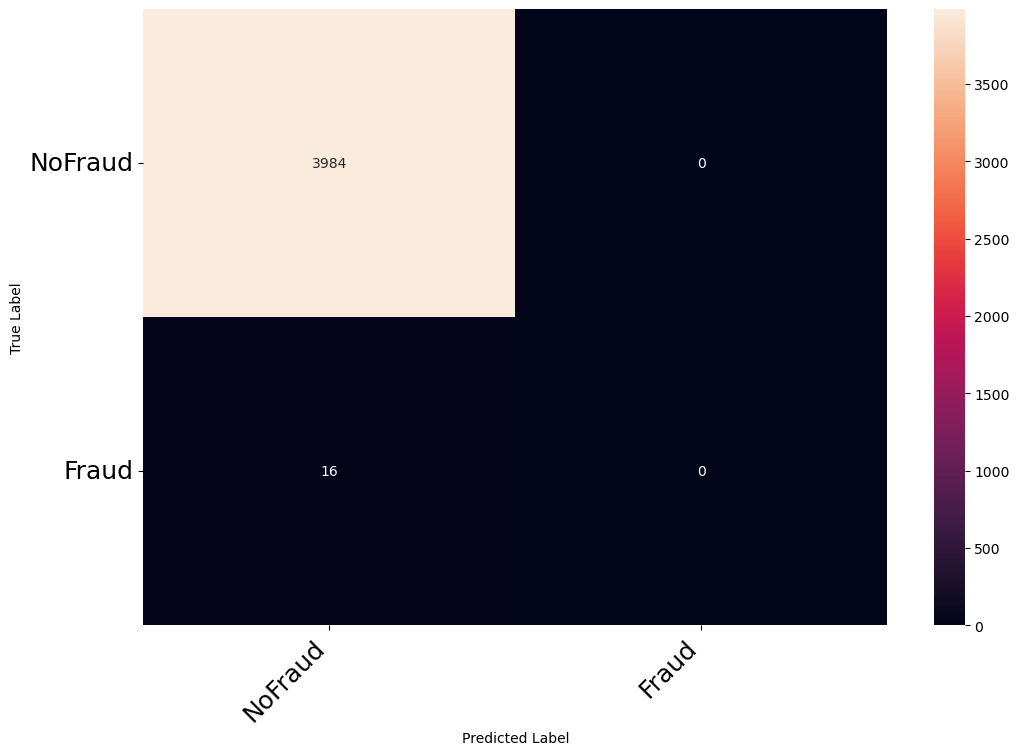

In [33]:
### logistic regresyon ile kurdugumuz modelimizin genel başarısı baya iyi olsa da azınlık sınıfı dogru tahmın etmekte cok zorlanıyor
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print_confusion_matrix(conf_mat, ['NoFraud', 'Fraud'])

In [34]:
def evaluate_model(model, X, y, pred_label=1):

    """
    This function evaluates your model and interprets the classification metrics results in a DataFrame format.
    
    Input
    ---------
    model: Classification Model
    X: Features
    y: Label
    pred_label: Which label will be used for interprets the results
        
    Output
    -------
    metric_df: Result DataFrame
    """
    
    y_pred = model.predict(X)

    accuracy = round(accuracy_score(y, y_pred), 3)
    recall = round(recall_score(y, y_pred, pos_label = pred_label), 3)
    precision = round(precision_score(y, y_pred, pos_label = pred_label), 3)
    f1 = round(f1_score(y, y_pred, pos_label = pred_label), 3)
    auc_score = round(roc_auc_score(y, y_pred), 3)

    metric_df = pd.DataFrame([accuracy, recall, precision, f1, auc_score]).T
    metric_df.index = ["Class " + str(pred_label)]
    metric_df.columns = ["Accuracy", "Recall", "Precision", "F1 Score", "AUC Score"]

    return metric_df

In [35]:
evaluate_model(lm1, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.996,1.0,0.996,0.998,0.5


In [36]:
evaluate_model(lm1, X_test_transformed, y_test, pred_label=1)  ##class 1 için f1 score ne kadar düşük!!!

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.996,0.0,0.0,0.0,0.5


In [37]:
## random oversampling

In [38]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train_transformed, y_train)

In [39]:
Counter(y_resampled)

Counter({'isFraud': 1})

In [40]:
svc_ros = SVC(probability=True).fit(X_resampled, y_resampled)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


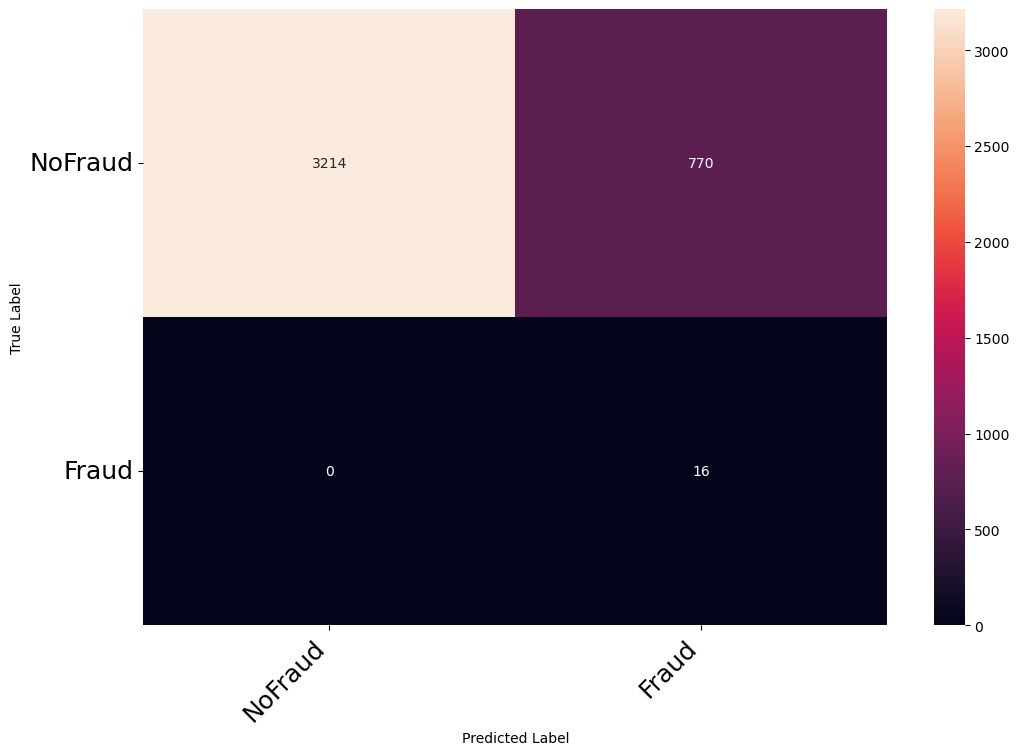

In [41]:
print_confusion_matrix(confusion_matrix(y_test, svc_ros.predict(X_test_transformed)), ['NoFraud', 'Fraud'])

In [42]:
evaluate_model(svc_ros, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.808,0.807,1.0,0.893,0.903


In [43]:
evaluate_model(svc_ros, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.808,1.0,0.02,0.04,0.903


In [44]:
#smoote

In [45]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE().fit_resample(X_train_transformed, y_train)
Counter(y_smoted)

Counter({'isFraud': 1})

In [46]:
svc_smote = SVC(probability=True).fit(X_smoted, y_smoted)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


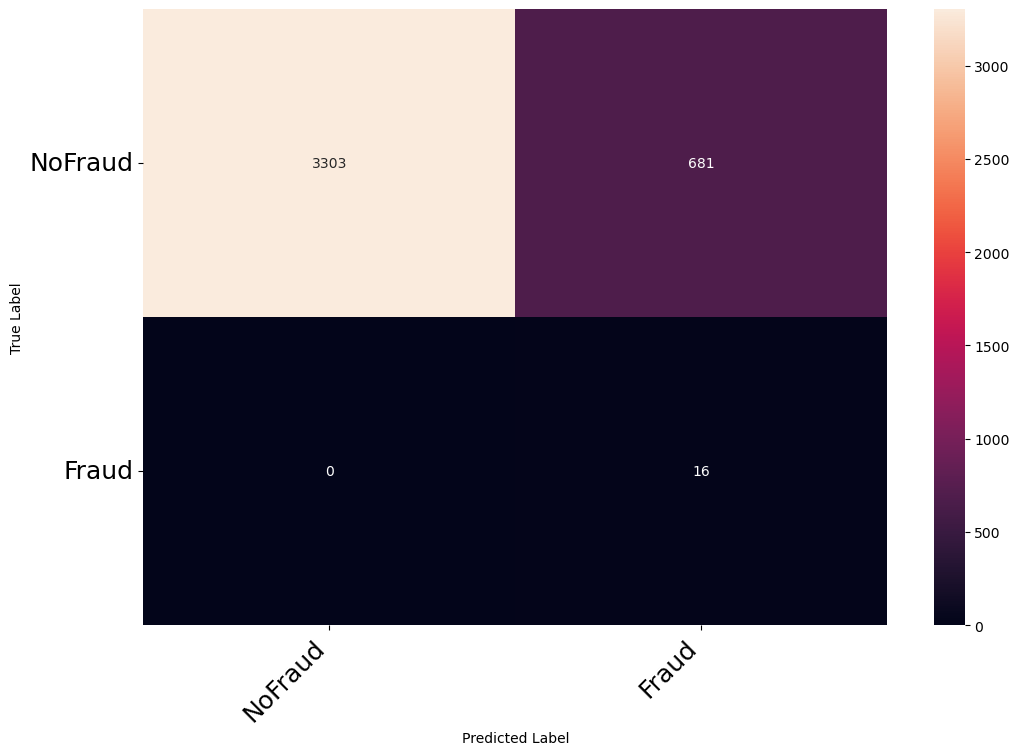

In [47]:
print_confusion_matrix(confusion_matrix(y_test, svc_smote.predict(X_test_transformed)), ['NoFraud', 'Fraud'])

In [48]:
evaluate_model(svc_smote, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.83,0.829,1.0,0.907,0.915


In [49]:
evaluate_model(svc_smote, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.83,1.0,0.023,0.045,0.915


In [50]:
## adsyn

In [51]:
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN().fit_resample(X_train_transformed, y_train)
Counter(y_adasyn)

Counter({'isFraud': 1})

In [52]:
svc_adasyn = SVC(probability=True).fit(X_adasyn, y_adasyn)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


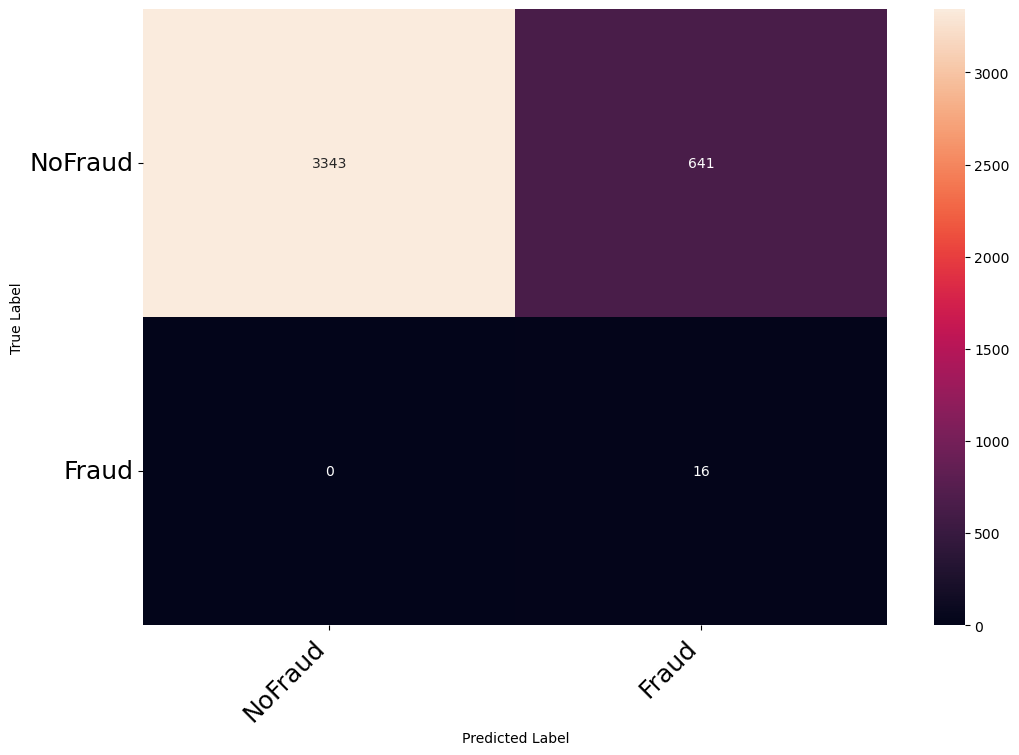

In [53]:
print_confusion_matrix(confusion_matrix(y_test, svc_adasyn.predict(X_test_transformed)), ['NoFraud', 'Fraud'])

In [54]:
evaluate_model(svc_adasyn, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.84,0.839,1.0,0.913,0.92


In [55]:
evaluate_model(svc_adasyn, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.84,1.0,0.024,0.048,0.92


In [56]:
##borderline smoot

In [57]:
from imblearn.over_sampling import BorderlineSMOTE
X_blsmote, y_blsmote = BorderlineSMOTE().fit_resample(X_train_transformed, y_train)
Counter(y_blsmote)

Counter({'isFraud': 1})

In [58]:
svc_blsmote = SVC(probability=True).fit(X_blsmote, y_blsmote)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


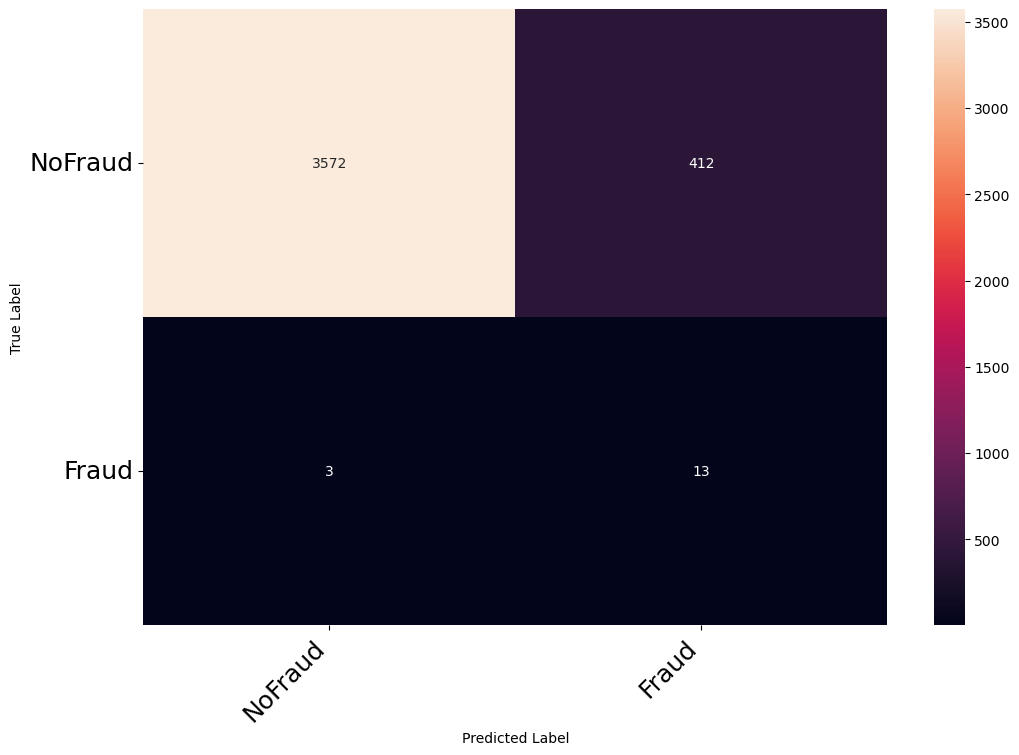

In [59]:
print_confusion_matrix(confusion_matrix(y_test, svc_blsmote.predict(X_test_transformed)), ['NoFraud', 'Fraud'])

In [60]:
evaluate_model(svc_blsmote, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.896,0.897,0.999,0.945,0.855


In [61]:
evaluate_model(svc_blsmote, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.896,0.812,0.031,0.059,0.855


In [62]:
### random oversampling işlemini SVC dışında bir model ile denedim.

In [110]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train_transformed, y_train)

In [111]:
lm2 = LogisticRegression().fit(X_resampled, y_resampled)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


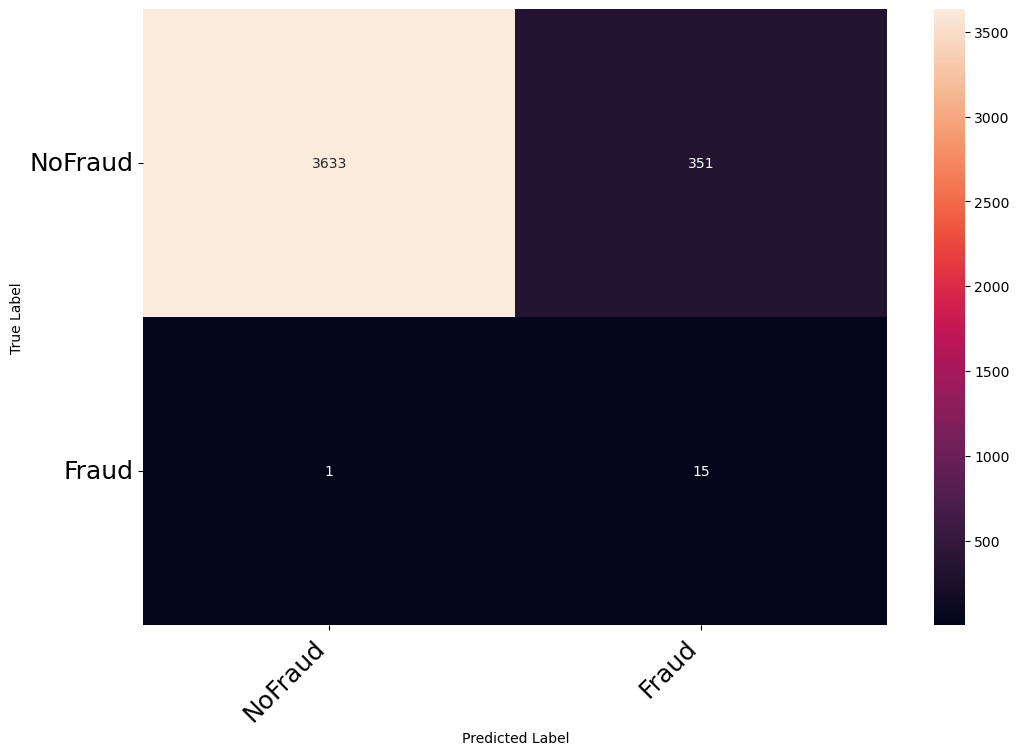

In [112]:
print_confusion_matrix(confusion_matrix(y_test, lm2.predict(X_test_transformed)), ['NoFraud', 'Fraud'])

In [113]:
evaluate_model(lm2, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.912,0.912,1.0,0.954,0.925


In [114]:
evaluate_model(lm2, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.912,0.938,0.041,0.079,0.925


In [115]:
### cok buyuk veri ile çalışmadıgımız ıcın undersampling denemedim

In [116]:
###########################################################################################################################

In [117]:
####          K    N     N  ile model oluşturma  ##################################

In [118]:
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier()
scores = cross_val_score(knn, X_test_transformed, y_test, cv=10, scoring='accuracy') # Veri setini 10 farklı formatta hazırla
print(scores)

[0.998 0.998 0.998 0.998 0.995 0.995 0.995 0.995 0.995 0.995]


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

In [119]:
##featutureları standart hale getirelim
std_scale = StandardScaler()
X_train_transformed = std_scale.fit_transform(X_train) 
X_test_transformed = std_scale.transform(X_test) 

knn1 = KNeighborsClassifier()
knn1.fit(X_train_transformed, y_train)

print('knn Training Score: {:6.2f}%'.format(100*knn1.score(X_train_transformed, y_train)))
print('knn Test Score: {:6.2f}%'.format(100*knn1.score(X_test_transformed, y_test)))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


knn Training Score:  99.71%
knn Test Score:  99.62%


In [120]:
##knn modeli için en iyi parametleri seçme  ## GRIDSEARCH

In [121]:
from sklearn.model_selection import GridSearchCV

In [122]:
# GridSearchCV'nin bakacağı k parametrelerini seçiyoruz
# Hangi parametrelerin değerlendirileceğini tanımlama
k_range = list(range(1, 40))
weight_options = ['uniform', 'distance']
metric_options = ['euclidean', 'manhattan', 'minkowski']


In [123]:
# Dictionary yapısını tekrardan kuruyoruz
param_grid = dict(n_neighbors=k_range, weights=weight_options, metric=metric_options)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'minkowski']}


In [124]:
# GridSearchCV'yi tanımlıyoruz
grid1 = GridSearchCV(knn1, param_grid, cv=5, scoring='accuracy')
grid1.fit(X_train_transformed, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [125]:
print('Best Score:', grid1.best_score_, 'Best Parameters:', grid1.best_params_)

Best Score: 0.9969999999999999 Best Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


In [126]:
knn1 = KNeighborsClassifier( n_neighbors=9,metric='manhattan',weights='distance')
knn1.fit(X_train_transformed, y_train)

print('KNN Training Score: {:6.2f}%'.format(100*knn1.score(X_train_scaled, y_train)))
print('KNN  Test Score: {:6.2f}%'.format(100*knn1.score(X_test_scaled, y_test)))

KNN Training Score: 100.00%
KNN  Test Score:  99.70%


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [127]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = [12,8], fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to [12,8].
    fontsize: int
        Font size for axes labels. Defaults to 18.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [128]:
y_pred = knn1.predict(X_test_transformed)

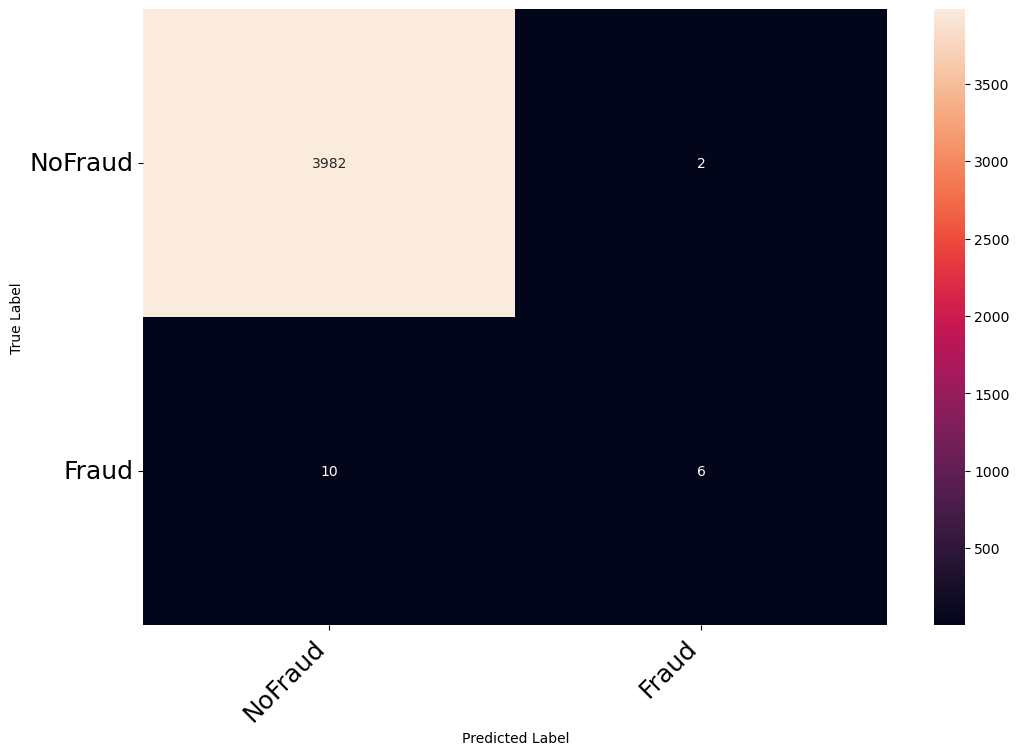

In [130]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print_confusion_matrix(conf_mat, ['NoFraud', 'Fraud'])

In [131]:
evaluate_model(knn1, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.997,0.999,0.997,0.998,0.687


In [132]:
evaluate_model(knn1, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.997,0.375,0.75,0.5,0.687


In [133]:
## random oversampling

In [134]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train_transformed, y_train)

In [135]:
knn = KNeighborsClassifier().fit(X_resampled, y_resampled)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


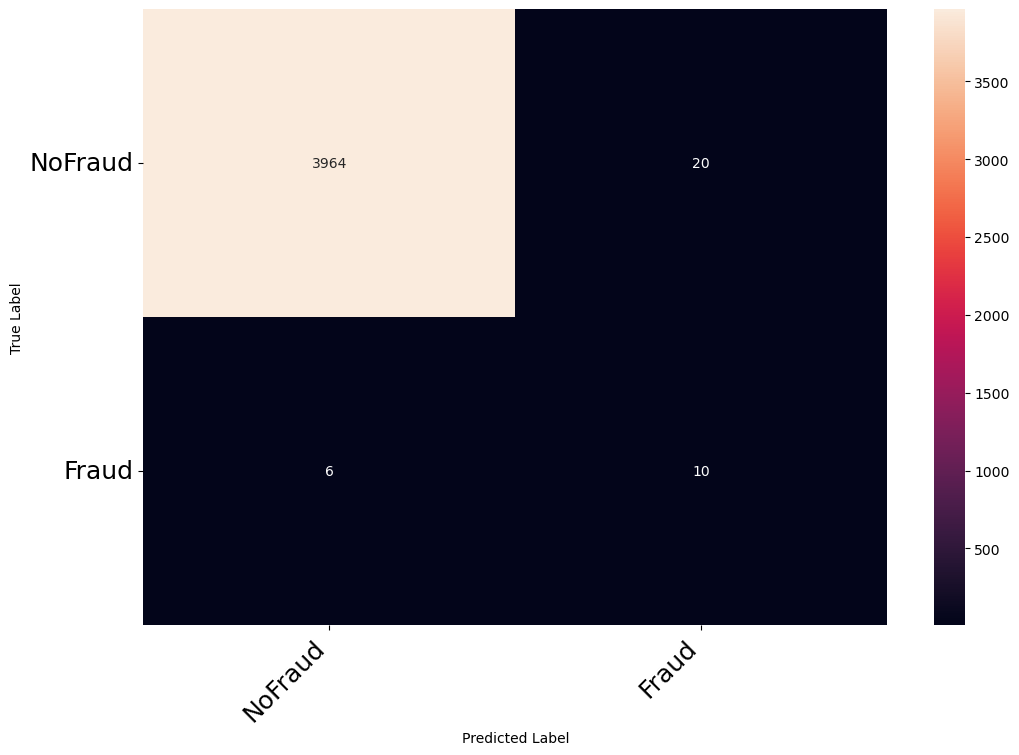

In [136]:
print_confusion_matrix(confusion_matrix(y_test, knn.predict(X_test_transformed)), ['NoFraud', 'Fraud'])

In [137]:
evaluate_model(knn, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.994,0.995,0.998,0.997,0.81


In [138]:
evaluate_model(knn, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.994,0.625,0.333,0.435,0.81


In [139]:
#smote

In [140]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE().fit_resample(X_train_transformed, y_train)

In [141]:
knn = KNeighborsClassifier().fit(X_smoted, y_smoted)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


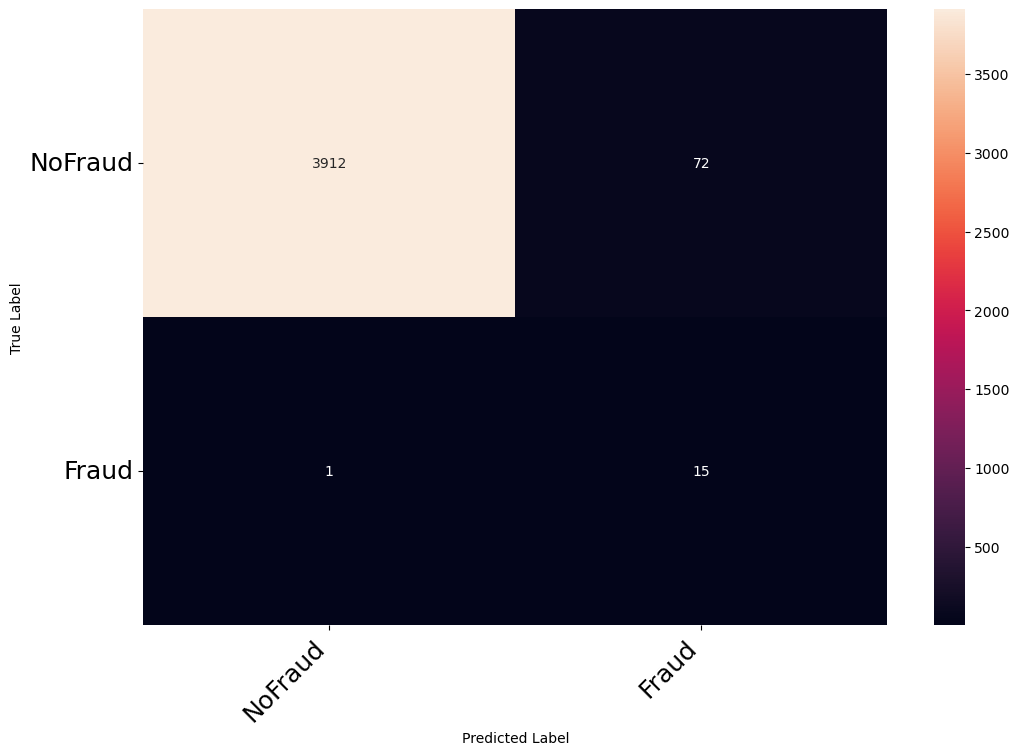

In [142]:
print_confusion_matrix(confusion_matrix(y_test, knn.predict(X_test_transformed)), ['NoFraud', 'Fraud'])

In [143]:
evaluate_model(knn, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.982,0.982,1.0,0.991,0.96


In [144]:
evaluate_model(knn, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.982,0.938,0.172,0.291,0.96


In [145]:
#ADSYN

In [146]:
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN().fit_resample(X_train_transformed, y_train)

In [147]:
knn = KNeighborsClassifier().fit(X_adasyn, y_adasyn)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


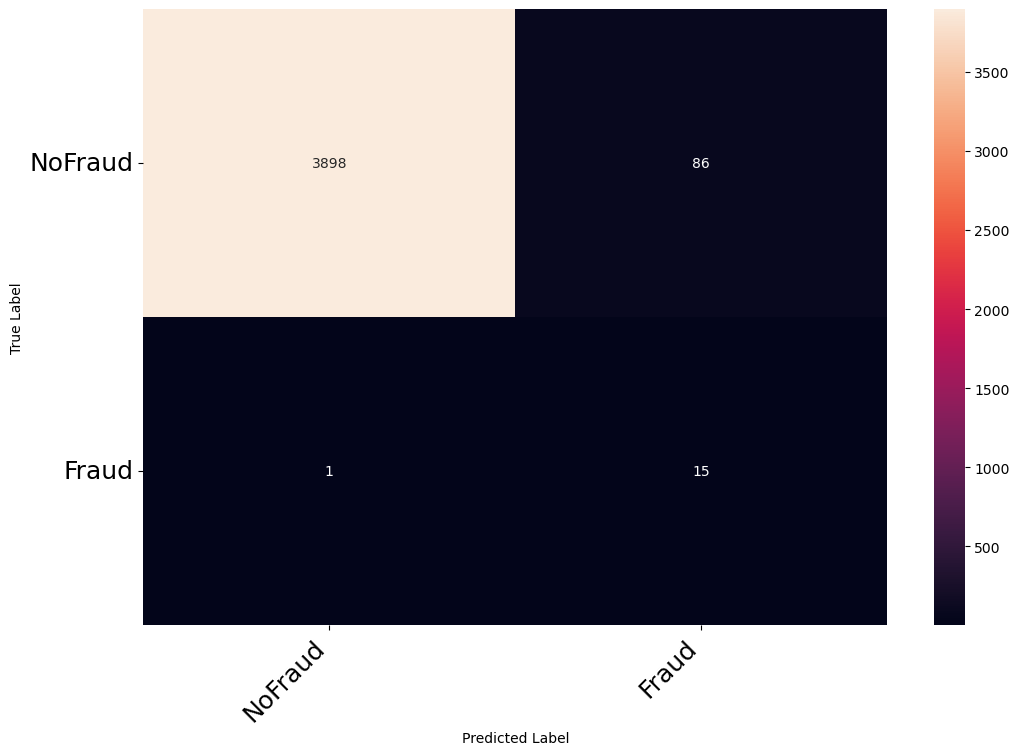

In [148]:
print_confusion_matrix(confusion_matrix(y_test, knn.predict(X_test_transformed)), ['NoFraud', 'Fraud'])

In [149]:
evaluate_model(knn, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.978,0.978,1.0,0.989,0.958


In [150]:
evaluate_model(knn, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.978,0.938,0.149,0.256,0.958


In [151]:
##borderline smote

In [152]:
from imblearn.over_sampling import BorderlineSMOTE
X_blsmote, y_blsmote = BorderlineSMOTE().fit_resample(X_train_transformed, y_train)

In [153]:
knn = KNeighborsClassifier().fit(X_blsmote, y_blsmote)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


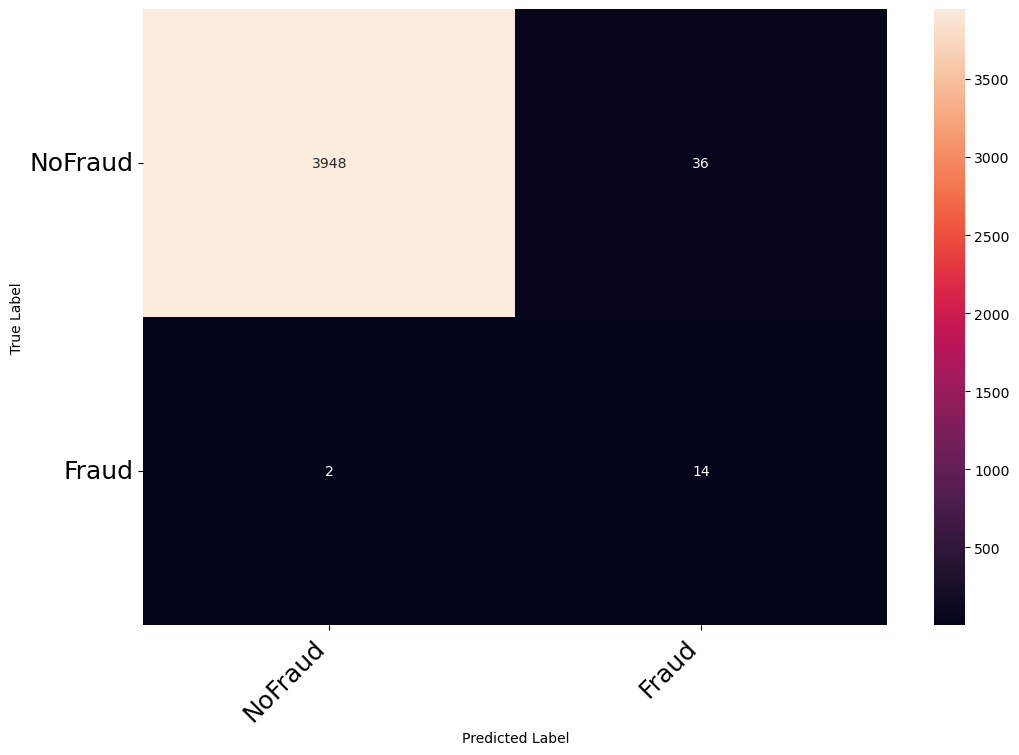

In [154]:
print_confusion_matrix(confusion_matrix(y_test, knn.predict(X_test_transformed)), ['NoFraud', 'Fraud'])

In [155]:
evaluate_model(knn, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.99,0.991,0.999,0.995,0.933


In [156]:
evaluate_model(knn, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.99,0.875,0.28,0.424,0.933


In [157]:
############### ağaç algolarına geçelim

In [158]:
### decısıon tree model

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.2, random_state=42, stratify=y)

In [160]:
dt_model=DecisionTreeClassifier().fit(X_train,y_train)

In [161]:
y_pred_dt=dt_model.predict(X_test)

In [162]:
confusion_matrix(y_test, y_pred_dt)

array([[3981,    3],
       [   3,   13]], dtype=int64)

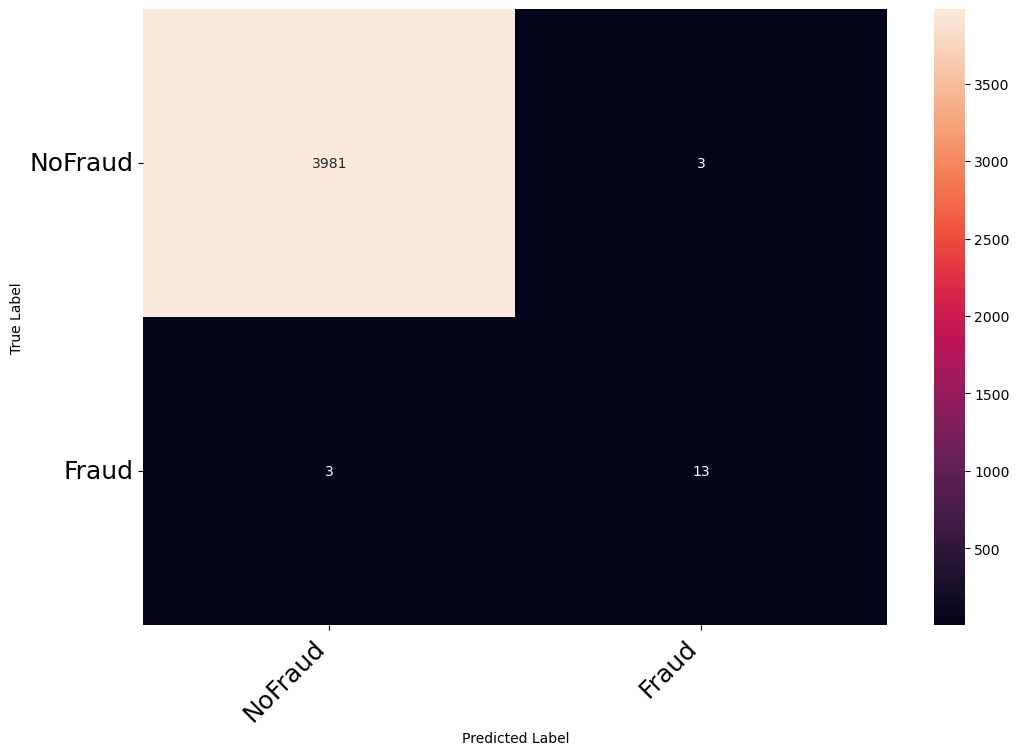

In [163]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_dt)
print_confusion_matrix(conf_mat, ['NoFraud', 'Fraud'])

In [164]:
importances_dt = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(dt_model.feature_importances_,3)})
importances_dt = importances_dt.sort_values('Importance', ascending=False).set_index('Feature')
importances_dt

,Importance
Feature,
amount,0.427
oldbalanceOrg,0.424
type,0.145
newbalanceOrig,0.004


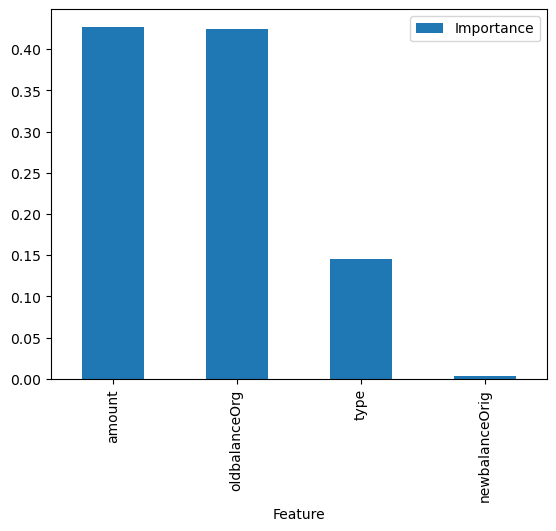

In [165]:
importances_dt.plot.bar();    ## modeldeki featurelarımızın önem dereceleleri
## her modeli tüm featurelar üzerinden kurup sonrasında en başarılı model üzerinden feature ekleme ve cıkarma işelmleri 
## yapmayı planladım

In [166]:
evaluate_model(dt_model, X_test, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.998,0.999,0.999,0.999,0.906


In [167]:
evaluate_model(dt_model, X_test, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.998,0.812,0.812,0.812,0.906


In [168]:
### random forest model

In [169]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier()

In [170]:
y_pred_rf = rf_model.predict(X_test)
confusion_matrix(y_test, y_pred_rf)

array([[3983,    1],
       [   6,   10]], dtype=int64)

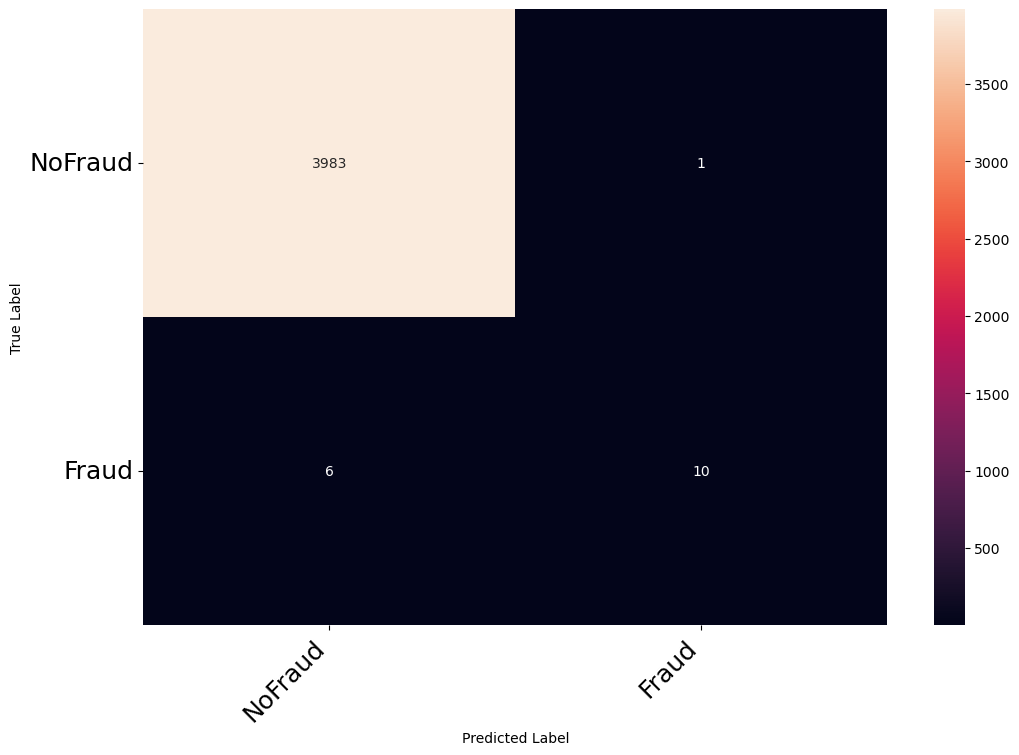

In [171]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_rf)
print_confusion_matrix(conf_mat, ['NoFraud', 'Fraud'])

In [172]:
importances_rf = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(rf_model.feature_importances_,3)})
importances_rf = importances_rf.sort_values('Importance', ascending=False).set_index('Feature')
importances_rf

,Importance
Feature,
amount,0.486
oldbalanceOrg,0.449
type,0.044
newbalanceOrig,0.022


In [173]:
evaluate_model(rf_model, X_test, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.998,1.0,0.998,0.999,0.812


In [174]:
evaluate_model(rf_model, X_test, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.998,0.625,0.909,0.741,0.812


In [175]:
###xgboost model

In [275]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [276]:
y_pred_xgb = xgb_model.predict(X_test)
confusion_matrix(y_test, y_pred_xgb)

array([[3983,    1],
       [   4,   12]], dtype=int64)

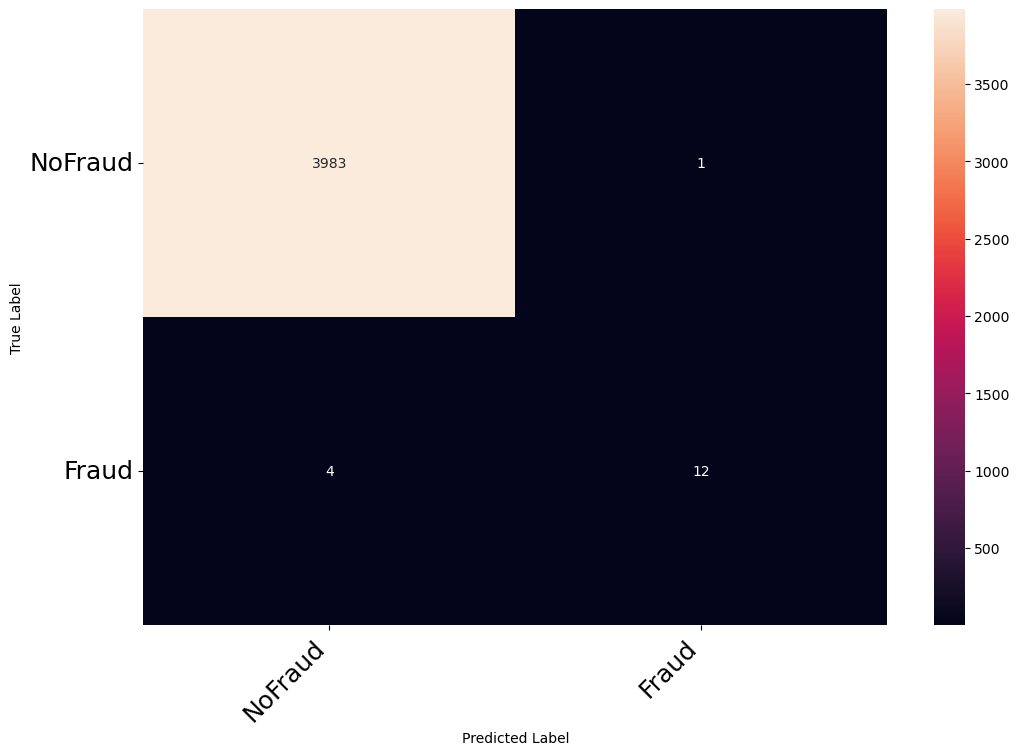

In [277]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_xgb)
print_confusion_matrix(conf_mat, ['NoFraud', 'Fraud'])

In [278]:
importances_xgb = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(rf_model.feature_importances_,3)})
importances_xgb = importances_xgb.sort_values('Importance', ascending=False).set_index('Feature')
importances_xgb

,Importance
Feature,
amount,0.486
oldbalanceOrg,0.449
type,0.044
newbalanceOrig,0.022


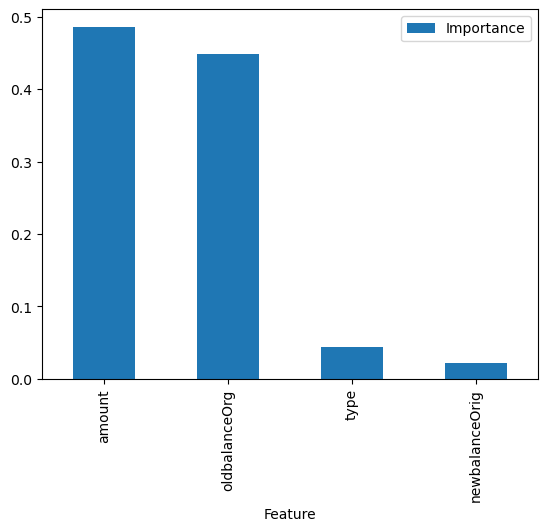

In [279]:
importances_xgb.plot.bar();

In [280]:
evaluate_model(xgb_model, X_test, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.999,1.0,0.999,0.999,0.875


In [281]:
evaluate_model(xgb_model, X_test, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.999,0.75,0.923,0.828,0.875


In [282]:
### ağaçlar içinden xgboost ile devam edelim

In [283]:
## random over sampling yapalım

In [284]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [285]:
xgb_ros = XGBClassifier().fit(X_resampled, y_resampled)

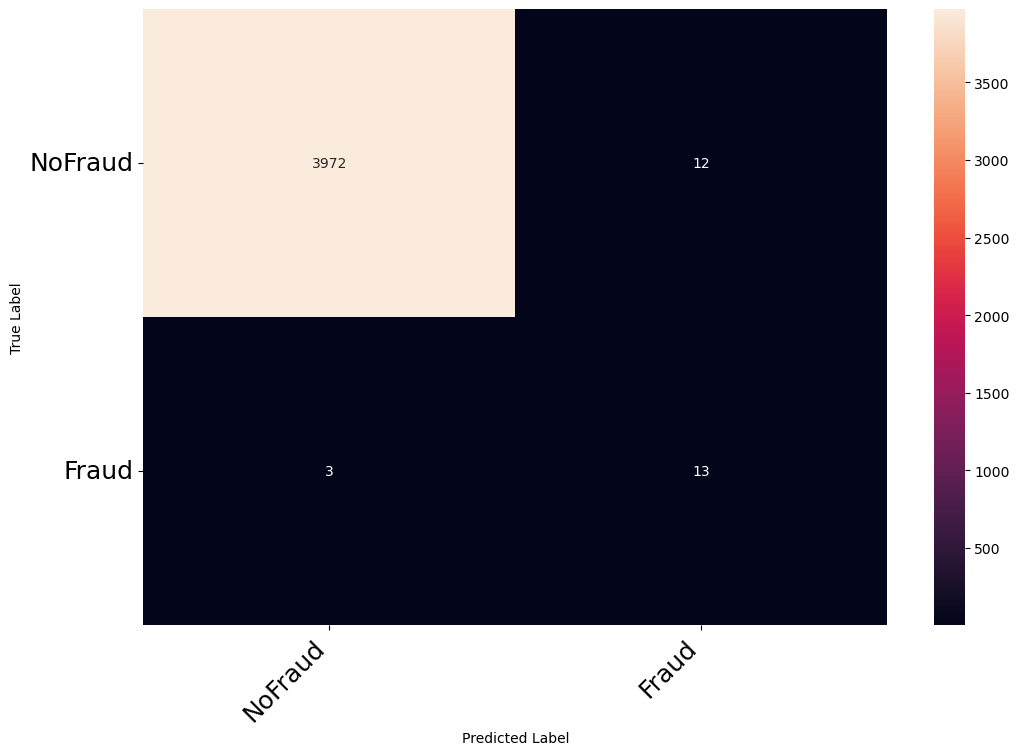

In [286]:
print_confusion_matrix(confusion_matrix(y_test, xgb_ros.predict(X_test)), ['NoFraud', 'Fraud'])

In [287]:
evaluate_model(xgb_ros, X_test, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.996,0.997,0.999,0.998,0.905


In [288]:
evaluate_model(xgb_ros, X_test, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.996,0.812,0.52,0.634,0.905


In [289]:
##smote 

In [290]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE().fit_resample(X_train, y_train)

In [291]:
xgb_smote = XGBClassifier().fit(X_smoted, y_smoted)

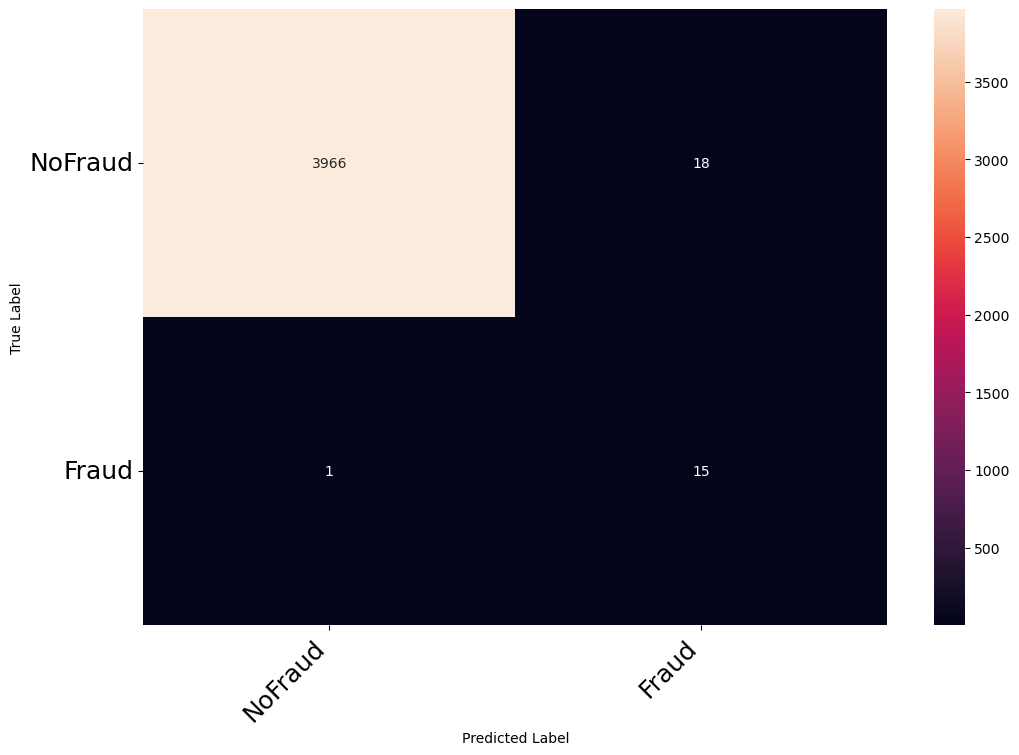

In [292]:
print_confusion_matrix(confusion_matrix(y_test, xgb_smote.predict(X_test)), ['NoFraud', 'Fraud'])

In [293]:
evaluate_model(xgb_smote, X_test, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.995,0.995,1.0,0.998,0.966


In [294]:
evaluate_model(xgb_smote, X_test, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.995,0.938,0.455,0.612,0.966


In [295]:
#ADASYN

In [296]:
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN().fit_resample(X_train, y_train)

In [297]:
xgb_adasyn = XGBClassifier().fit(X_adasyn, y_adasyn)

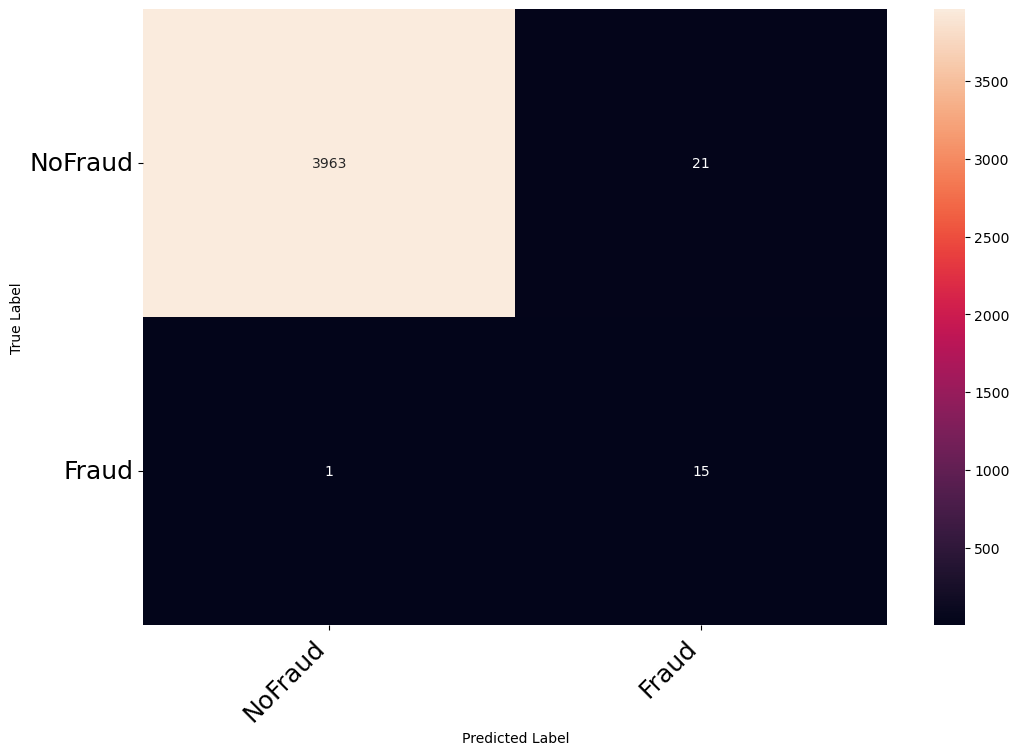

In [298]:
print_confusion_matrix(confusion_matrix(y_test, xgb_adasyn.predict(X_test)), ['NoFraud', 'Fraud'])

In [299]:
evaluate_model(xgb_adasyn, X_test, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.994,0.995,1.0,0.997,0.966


In [300]:
evaluate_model(xgb_adasyn, X_test, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.994,0.938,0.417,0.577,0.966


In [301]:
##blsmote

In [302]:
from imblearn.over_sampling import BorderlineSMOTE
X_blsmote, y_blsmote = BorderlineSMOTE().fit_resample(X_train, y_train)

In [303]:
xgb_blsmote = XGBClassifier().fit(X_blsmote, y_blsmote)

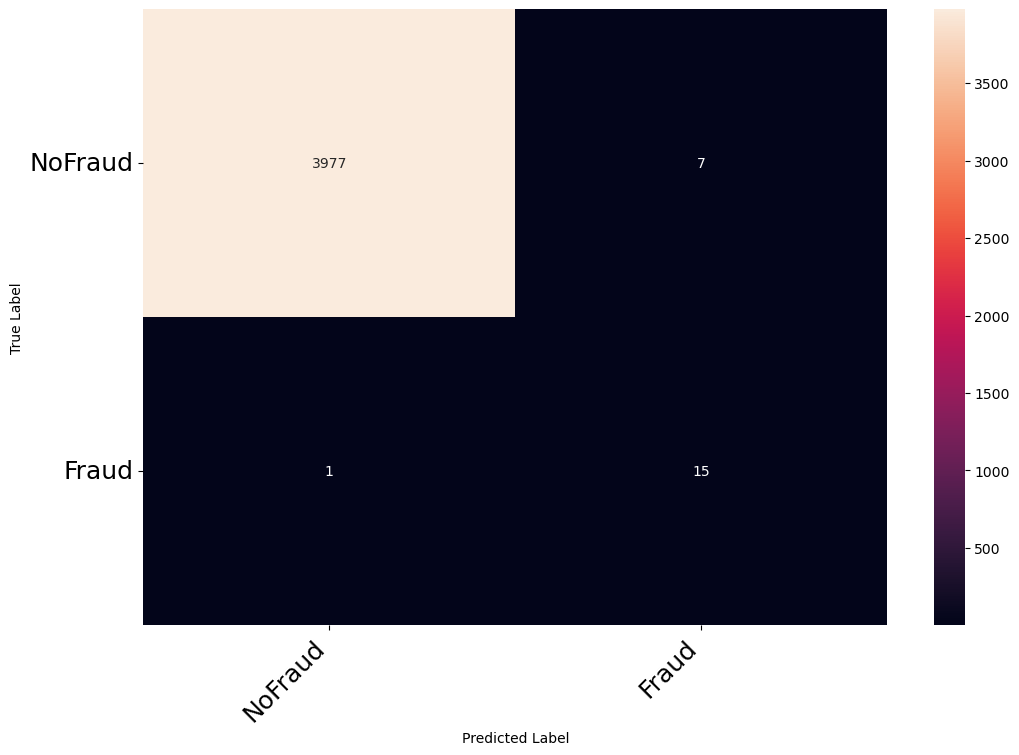

In [304]:
print_confusion_matrix(confusion_matrix(y_test, xgb_blsmote.predict(X_test)), ['NoFraud', 'Fraud'])

In [305]:
evaluate_model(xgb_blsmote, X_test, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.998,0.998,1.0,0.999,0.968


In [306]:
evaluate_model(xgb_blsmote, X_test, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.998,0.938,0.682,0.789,0.968


In [307]:
## en başarılı model olarak xboost un borderline smote versiyonunu kabul edelim

In [308]:
## bu model için farklı eşik degerleri ile denemeler yapalım

In [309]:
def make_confusion_matrix(model, threshold=0.50): # Ön tanımlı threshold değeri
    
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['NoFraud', 'Fraud'],
           yticklabels=['NoFraud', 'Fraud']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

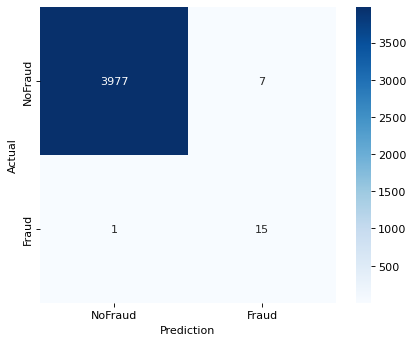

In [315]:
make_confusion_matrix(xgb_blsmote)

In [316]:
# Threshold değerini değiştirdiğimizde sonucun da interaktif bir şekilde değişmesi için bir widget

from ipywidgets import interactive

interactive(lambda threshold: make_confusion_matrix(xgb_blsmote, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [317]:
y_predict = xgb_blsmote.predict(X_test)
print('Default Threshold: 0.5')
print('Precision: {:6.3f},   Recall: {:6.3f}'.format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default Threshold: 0.5
Precision:  0.682,   Recall:  0.938


In [318]:
# 0.10 threshold değerine göre sınıflandırma
new_threshold = 0.10
y_predict = (xgb_blsmote.predict_proba(X_test)[:,1] > new_threshold)
print('New Threshold:', new_threshold)
print('Precision: {:6.3f},   Recall: {:6.3f}'.format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

New Threshold: 0.1
Precision:  0.600,   Recall:  0.938


In [319]:
### SHAP

In [320]:
from imblearn.over_sampling import BorderlineSMOTE
X_blsmote, y_blsmote = BorderlineSMOTE().fit_resample(X_train, y_train)



In [321]:
xgb_blsmote = XGBClassifier().fit(X_blsmote, y_blsmote)

In [322]:
explainer = shap.Explainer(xgb_blsmote)
shap_values_classification = explainer(X_test)

[16:47:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [323]:
shap.initjs()

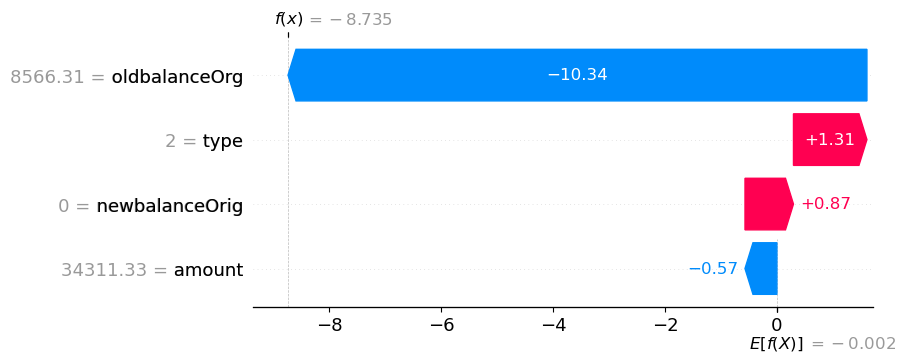

In [324]:
shap.plots.waterfall(shap_values_classification[0])

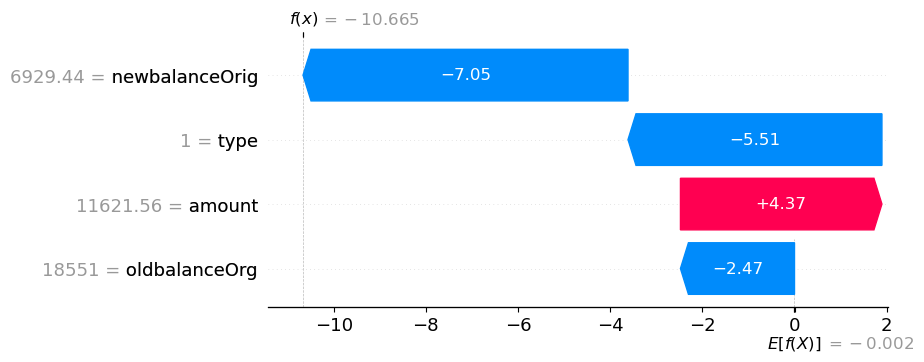

In [325]:
shap.plots.waterfall(shap_values_classification[10])

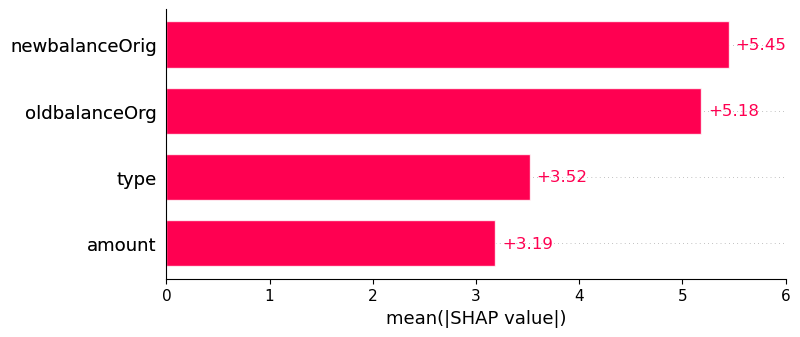

In [326]:
shap.plots.bar(shap_values_classification)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


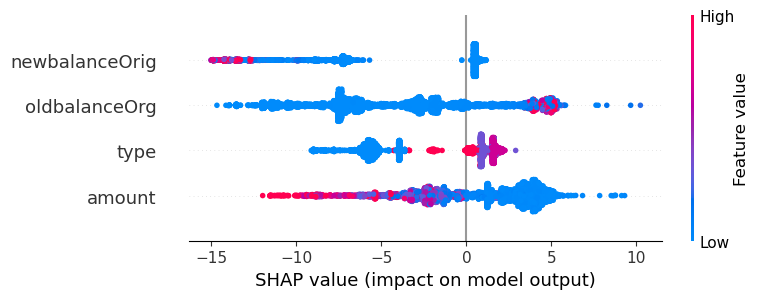

In [327]:
shap.summary_plot(shap_values_classification, X_test)